# importing librarries and packages

In [49]:
import numpy as np
import netCDF4
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable


Add path for `algorithm.py` to you path

In [2]:
import sys
sys.path.append('../Codes/')

# Import `LFD_NDVI_Method`

In [3]:
from algorithm import LFD_NDVI

# User-defined function

define a function to apply LFD method over different pixels

In [4]:
def LFD_Over_Pixels(y, date):
    # Define an internal function to apply LFD over different years
    def LFD_Over_Years(YR):

        # indexation to seperate data for each specific year
        ind = Year == YR
        x_in = x[ind]
        y_in = y[ind]

        # call LFD method to do calculation for each individual year
        OG, OD, OG_ndviC, OD_ndviC, peak_Timing, PearsonCorrelation = LFD_NDVI(x_in, y_in, YR[0], 'off')
        return OG, OD, OG_ndviC, OD_ndviC, peak_Timing, PearsonCorrelation
    # end of function

    ###### Do the calculations ####################################################################
    # get corresponding day of year for dates
    x = np.array(date.day_of_year)

    # get corresponding years of dates
    Year = np.array(date.year)

    # find unique years during the examined period
    Unique_year = np.unique(np.array(date.year))
    Unique_year = Unique_year.reshape((1, len(Unique_year)))

    # Call internal Function to apply LFD method over different years
    OG, OD, OG_ndviC, OD_ndviC, peak_Timing, PearsonCorrelation = np.apply_along_axis(LFD_Over_Years, 0, Unique_year)
    return OG, OD, OG_ndviC, OD_ndviC, peak_Timing, PearsonCorrelation

# Read MODIS data

In [5]:
nc = netCDF4.Dataset('../Data/SampleData.nc')
ndvi = nc.variables['ndvi']
lat = np.array(nc.variables['lat'])
lon = np.array(nc.variables['lon'])

# Define the date vector in Monthly resolution
date = pd.period_range(start="2001-01-01",end="2020-12-31",freq="M")

# Apply LFD Method
Call LFD method and apply it for axis = 0 (time axis)


In [6]:
OG, OD, OG_ndviC, OD_ndviC, peak_Timing, PearsonCorrelation = np.apply_along_axis(LFD_Over_Pixels, 
                                                                                  0, 
                                                                                  ndvi, 
                                                                                  date)


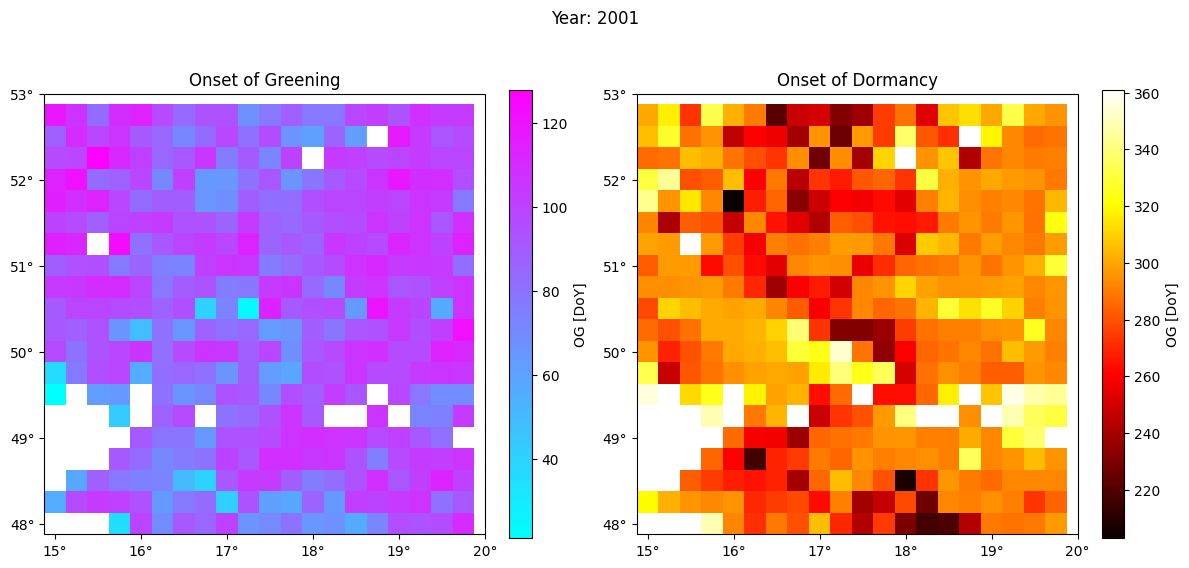

In [61]:
years = np.arange(2001, 2021)  # Example years for each time step
time_steps = 20

# Set up the figure and axis with Cartopy
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 6))

# Define the update function for each frame in the animation
def update(frame):
    ax1.clear()
    ax2.clear()

    fig.suptitle(f"Year: {years[frame]}")
    ax1.set_title(f"Onset of Greening")
    ax2.set_title(f"Onset of Dormancy")

    # Plot data for the current time step
    data_slice_OG = OG[frame, :, :]
    data_slice_OD = OD[frame, :, :]

    mesh_OG = ax1.pcolormesh(lon, lat, data_slice_OG, transform=ccrs.PlateCarree(), shading='auto', cmap='cool')
    mesh_OD = ax2.pcolormesh(lon, lat, data_slice_OD, transform=ccrs.PlateCarree(), shading='auto', cmap='hot')

    # Add latitude and longitude labels
    ax1.set_xticks(np.arange(lon.min(), lon.max()+1, 1), crs=ccrs.PlateCarree())  # Longitude ticks
    ax1.set_yticks(np.arange(lat.min(), lat.max()+1, 1), crs=ccrs.PlateCarree())    # Latitude ticks
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))

    # Add latitude and longitude labels
    ax2.set_xticks(np.arange(lon.min(), lon.max()+1, 1), crs=ccrs.PlateCarree())  # Longitude ticks
    ax2.set_yticks(np.arange(lat.min(), lat.max()+1, 1), crs=ccrs.PlateCarree())    # Latitude ticks
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))

    return mesh_OG, mesh_OD    

# Create the animation
ani = FuncAnimation(fig, update, frames=range(time_steps), repeat=False)

# Return first figure to add colobar
mesh_OG, mesh_OD = update(0)

# Add colorbar
cbar1 = fig.colorbar(mesh_OG, ax=ax1, orientation="vertical", fraction=0.046, pad=0.05, label="OG [DoY]")
cbar2 = fig.colorbar(mesh_OD, ax=ax2, orientation="vertical", fraction=0.046, pad=0.05, label="OG [DoY]")
fig.tight_layout()

# Display the animation inline in Jupyter Notebook
HTML(ani.to_jshtml())


# to save as an MP4 or GIF

In [62]:
ani.save("timelapse_map.mp4", writer="ffmpeg", dpi=150)